# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [ ]:
#Name: Justin Garzione
#NetID: justing6

In [246]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random, randrange
import time
import math
from skimage import io, util
import heapq
#from skimage.transform import rescale, resize

### Part I: Randomly Sampled Texture (10 pts)

In [247]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    #Build New Array (Target) of output size
    newarray = np.ones((out_size,out_size,3), dtype=int)
    
    #Starting X,Y coordinates for blocks in the Target
    start_y = int((len(newarray[:,1])%patch_size)/2)
    start_y1 = int((len(newarray[:,1])%patch_size)/2)
    start_x = int((len(newarray[1,:])%patch_size)/2)
    start_x1 = int((len(newarray[1,:])%patch_size)/2)
    
    #Print the input shape
    print("Input shape is: ", np.shape(sample))
    print("Output shape is: ", np.shape(newarray))
    
    #Test if the patches divide evenly in into output
    if(out_size % patch_size == 0):
        print('Patch size is evenly divisible; no border in this image.')
    else:
        print('Patch size is not evenly divisible')
    
    #Show the starting coordinates of the New Array (target)
    print('New Array Starting Coordinates: (',start_x,',',start_y,')')
    
    #Number of iterations through the New Array in order to fill with patches
    patches_wide = math.floor(len(newarray[1,:])/(patch_size))
    patches_high = math.floor(len(newarray[:,1])/(patch_size))
    
    #Upper bounds for random coordinates for seed patch
    in_rx = len(sample[1,:])-patch_size
    in_cy = len(sample[:,1])-patch_size
    
    #Loop through (x,y) -> get random -> paste into New Array -> Increment
    for y in range(patches_high):
        for x in range(patches_wide):
            rand_y = (int)(random()*in_cy)
            rand_x = (int)(random()*in_rx)
            newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = sample[rand_y:(rand_y+patch_size), rand_x:(rand_x+patch_size), :]
            start_x += patch_size
        start_x = start_x1
        start_y += patch_size
        
    #Return the New Array (Target)
    return newarray

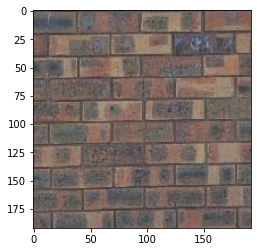

Input shape is:  (192, 192, 3)
Output shape is:  (200, 200, 3)
Patch size is evenly divisible; no border in this image.
New Array Starting Coordinates: ( 0 , 0 )


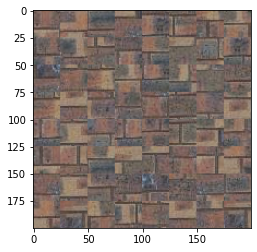

In [248]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 25
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [309]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    #Build New Array (Target) of output size
    newarray = np.ones((out_size,out_size,3), dtype=int)
    
    #Starting X,Y coordinates for blocks in the Target
    start_y = int((len(newarray[:,1])%(patch_size))/2)
    start_y1 = int((len(newarray[:,1])%(patch_size))/2)
    start_x = int((len(newarray[1,:])%(patch_size))/2)
    start_x1 = int((len(newarray[1,:])%(patch_size))/2)
    
    #Print the input and output shapes
    print("Input shape is: ", np.shape(sample))
    print("Output shape is: ", np.shape(newarray))
    
    #Test if the patches divide evenly in into output
    if(out_size % (patch_size) == 0):
        print('Patch size is evenly divisible; no border in this image.')
    else:
        print('Patch size is not evenly divisible')
    
    #Show the starting coordinates of the New Array (target)
    print('New Array Starting Coordinates: (',start_x1,',',start_y1,')')
    
    #Number of iterations through the New Array in order to fill with patches
    patches_wide = math.floor(len(newarray[1,:])/(patch_size-overlap))-1#new
    patches_high = math.floor(len(newarray[:,1])/(patch_size-overlap))-1#new
    
    print("The New Array will be filled: ",patches_high," patches high")
    print("The New Array will be filled: ",patches_wide," patches wide")

    #Loop through (x,y) -> get random -> paste into New Array -> Increment
    for y in range(patches_high):
        print("Getting patches for Row: ",y)
        for x in range(patches_wide):
            if y == x == 0:
                
                in_rx = len(sample[1,:])-patch_size
                in_cy = len(sample[:,1])-patch_size
                rand_y = (int)(random()*in_cy)
                rand_x = (int)(random()*in_rx)
                patch = sample[rand_y:(rand_y+patch_size), rand_x:(rand_x+patch_size), :]
                print("Generating random first patch")
                #patch = sample[0:(0+patch_size), 0:(0+patch_size), :]
                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size-overlap)
                
            else:
                
                patch = choose_sample(sample,patch_size,overlap,newarray,start_y,start_x,tol,start_y1,start_x1)
                #print("Patch shape is: ",np.shape(patch)," at position: (",x,",",y,")")
                
                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size-overlap)
                
        start_x = start_x1
        start_y += (patch_size-overlap)
        
    return newarray

In [369]:
def choose_sample(sample, block_size, overlap, newarray, start_y, start_x,tol,start_y1,start_x1):
    h, w, _ = sample.shape #Get the shape of the source image
    errormatrix = np.zeros((h - block_size, w - block_size)) #Build matrix for SSD
    tolerance_check = []      
    
    for i in range(h - block_size): #Loop in the X direction
        for j in range(w - block_size): #Loop in the Y direction
            source_patch = sample[i:i+block_size, j:j+block_size] #Patch take from source at each coordinate pair
            e = ssd_patch(source_patch, block_size, overlap, newarray, start_y, start_x,start_y1,start_x1) 
            errormatrix[i, j] = e
            tolerance_check.append((i,j,e))
                
    tolerance_check.sort(key=lambda x:x[2])
    randnum = randrange(tol)
    i , j , q = tolerance_check[randnum]
    #sample = util.img_as_float(sample)
    return sample[i:i+block_size, j:j+block_size]

In [370]:
def ssd_patch(source_patch, block_size, overlap, newarray, start_y, start_x,start_y1,start_x1):
    error = 0
    if start_x > start_x1:
        left = source_patch[:, :overlap] - newarray[start_y:start_y+block_size, start_x:start_x+overlap] #Vertical Comparison
        error += np.sum(left**2)

    if start_y > start_y1:
        up   = source_patch[:overlap, :] - newarray[start_y:start_y + overlap, start_x:start_x+block_size] #Horizontal Comparison
        error += np.sum(up**2)

    if start_y > start_y1 and start_x > start_x1:
        corner = source_patch[:overlap, :overlap] - newarray[start_y:start_y + overlap, start_x:start_x+overlap] #Intersection of above
        error -= np.sum(corner**2)
    
    return error

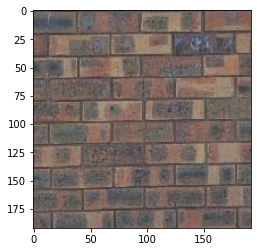

Input shape is:  (192, 192, 3)
Output shape is:  (300, 300, 3)
Patch size is evenly divisible; no border in this image.
New Array Starting Coordinates: ( 0 , 0 )
The New Array will be filled:  5  patches high
The New Array will be filled:  5  patches wide
Getting patches for Row:  0
Generating random first patch
Getting patches for Row:  1
Getting patches for Row:  2
Getting patches for Row:  3
Getting patches for Row:  4


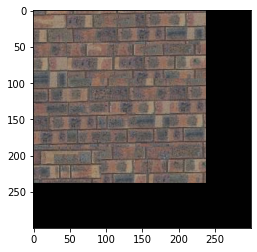

In [371]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 50
overlap = 3
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [333]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    #Build New Array (Target) of output size
    newarray = np.ones((out_size,out_size,3), dtype=int)
    newarray = util.img_as_float(newarray)
    sample = util.img_as_float(sample)
    
    #Starting X,Y coordinates for blocks in the Target
    start_y = int((len(newarray[:,1])%(patch_size))/2)
    start_y1 = int((len(newarray[:,1])%(patch_size))/2)
    start_x = int((len(newarray[1,:])%(patch_size))/2)
    start_x1 = int((len(newarray[1,:])%(patch_size))/2)
    
    #Print the input and output shapes
    print("Input shape is: ", np.shape(sample))
    print("Output shape is: ", np.shape(newarray))
    
    #Test if the patches divide evenly in into output
    if(out_size % (patch_size-overlap) == 0):
        print('Patch size is evenly divisible; no border in this image.')
    else:
        print('Patch size is not evenly divisible')
    
    #Show the starting coordinates of the New Array (target)
    print('New Array Starting Coordinates: (',start_x1,',',start_y1,')')
    
    #Number of iterations through the New Array in order to fill with patches
    patches_wide = math.floor(len(newarray[1,:])/(patch_size-overlap))-1
    patches_high = math.floor(len(newarray[:,1])/(patch_size-overlap))-1

    #Print patches high/wide
    print("The New Array will be filled: ",patches_high," patches high")
    print("The New Array will be filled: ",patches_wide," patches wide")
    
    #Upper bounds for random coordinates for seed patch
    in_rx = len(sample[1,:])-patch_size
    in_cy = len(sample[:,1])-patch_size
    
    #Loop through (x,y) -> get random -> paste into New Array -> Increment
    for y in range(patches_high):
        #print("Getting patches for row: ",y)
        print("...")
        for x in range(patches_wide):
            if y == x == 0:
                in_rx = len(sample[1,:])-patch_size
                in_cy = len(sample[:,1])-patch_size
                rand_y = (int)(random()*in_cy)
                rand_x = (int)(random()*in_rx)
                patch = sample[rand_y:(rand_y+patch_size), rand_x:(rand_x+patch_size), :]
                
                #patch = sample[0:(0+patch_size), 0:(0+patch_size), :]
                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size-overlap)
                continue
            else:
                
                patch = choose_sampleSpecial(sample,patch_size,overlap,newarray,start_y,start_x,tol,start_y1,start_x1)
                patch = customCut(patch, patch_size,overlap,newarray,start_y,start_x,start_y1,start_x1)
                
                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size -overlap)
        start_x = start_x1
        start_y += (patch_size - overlap)
    
    newarray = Image.fromarray((newarray * 255).astype(np.uint8))
    return newarray

In [334]:
#Make cut on minimum path
def customCut(patch, block_size, overlap, newarray, start_y, start_x, start_y1,start_x1):
    #Make copy of patch
    patch = patch.copy()
    #Get patch shape
    dy, dx, _ = patch.shape
    #Zero Matrix
    minCut = np.zeros_like(patch, dtype=bool)
    #Conditions for cutting vertically and horizontally
    if start_x > start_x1:
        error_left = patch[:, :overlap] - newarray[start_y:start_y+dy, start_x:start_x+overlap]
        leftL2 = np.sum(error_left**2, axis=2)
        for i, j in enumerate(cuttingPath(leftL2)):
            minCut[i, :j] = True

    if start_y > start_y1:
        error_up = patch[:overlap, :] - newarray[start_y:start_y+overlap, start_x:start_x+dx]
        upL2 = np.sum(error_up**2, axis=2)
        for j, i in enumerate(cuttingPath(upL2.T)):
            minCut[:i, j] = True

    np.copyto(patch, newarray[start_y:start_y+dy, start_x:start_x+dx], where=minCut)
    return patch

In [335]:
def cuttingPath(errors):
    errorq = [(error, [i]) for i, error in enumerate(errors[0])]
    heapq.heapify(errorq)

    h, w = errors.shape
    seen = set()

    while errorq:
        error, path = heapq.heappop(errorq)
        cutDepth = len(path)
        curIndex = path[-1]

        if cutDepth == h:
            return path

        for change in -1, 0, 1:
            nextIndex = curIndex + change

            if 0 <= nextIndex < w:
                if (cutDepth, nextIndex) not in seen:
                    cumError = error + errors[cutDepth, nextIndex]
                    heapq.heappush(errorq, (cumError, path + [nextIndex]))
                    seen.add((cutDepth, nextIndex))

In [ ]:
def choose_sampleSpecial(sample, block_size, overlap, newarray, start_y, start_x,tol,start_y1,start_x1):
    h, w, _ = sample.shape #Get the shape of the source image
    errormatrix = np.zeros((h - block_size, w - block_size)) #Build matrix for SSD
    tolerance_check = []      
    
    for i in range(h - block_size): #Loop in the X direction
        for j in range(w - block_size): #Loop in the Y direction
            source_patch = sample[i:i+block_size, j:j+block_size] #Patch take from source at each coordinate pair
            e = ssd_patch(source_patch, block_size, overlap, newarray, start_y, start_x,start_y1,start_x1) 
            errormatrix[i, j] = e
            tolerance_check.append((i,j,e))
                
    tolerance_check.sort(key=lambda x:x[2])
    randnum = randrange(tol)
    i , j , q = tolerance_check[randnum]
    sample = util.img_as_float(sample)
    return sample[i:i+block_size, j:j+block_size]

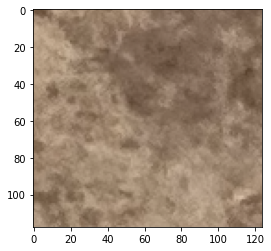

Input shape is:  (118, 124, 3)
Output shape is:  (200, 200, 3)
Patch size is evenly divisible; no border in this image.
New Array Starting Coordinates: ( 0 , 0 )
The New Array will be filled:  9  patches high
The New Array will be filled:  9  patches wide
...
...
...
...
...
...
...
...
...


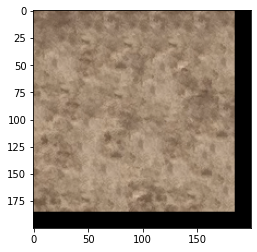

In [350]:
sample_img_fn = 'samples/floor_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 25
overlap = 5
tol = 2
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [351]:
def texture_transfer(sample, patch_size, overlap, tol, guidance, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    #Build New Array (Target) of output size
    newarray = np.ones(np.shape(guidance), dtype=int)
    
    #Make them all floating point
    newarray = util.img_as_float(newarray)
    guidance = util.img_as_float(guidance)
    sample = util.img_as_float(sample)
    
    #Starting X,Y coordinates for blocks in the Target
    start_y = int((len(newarray[:,1])%(patch_size))/2)
    start_y1 = int((len(newarray[:,1])%(patch_size))/2)
    start_x = int((len(newarray[1,:])%(patch_size))/2)
    start_x1 = int((len(newarray[1,:])%(patch_size))/2)
    
    #Print the input and output shapes
    print("Input shape is: ", np.shape(sample))
    print("Output shape is: ", np.shape(newarray))
    
    #Test if the patches divide evenly in into output
    if(out_size % (patch_size-overlap) == 0):
        print('Patch size is evenly divisible; no border in this image.')
    else:
        print('Patch size is not evenly divisible')
    
    #Show the starting coordinates of the New Array (target)
    print('New Array Starting Coordinates: (',start_x1,',',start_y1,')')
    
    #Number of iterations through the New Array in order to fill with patches
    patches_wide = math.floor(len(newarray[1,:])/(patch_size))#new
    patches_high = math.floor(len(newarray[:,1])/(patch_size))#new
    
    #Print patches high/wide
    print("The New Array will be filled: ",patches_high," patches high")
    print("The New Array will be filled: ",patches_wide," patches wide")
    
    #Upper bounds for random coordinates for seed patch
    in_rx = len(sample[1,:])-patch_size
    in_cy = len(sample[:,1])-patch_size
    
    #Loop through (x,y) -> get random -> paste into New Array -> Increment
    for y in range(patches_high):
        print("Getting patches for row: ",y)
        for x in range(patches_wide):
            if y == x == 0:
                #in_rx = len(sample[1,:])-patch_size
                #in_cy = len(sample[:,1])-patch_size
                #rand_y = (int)(random()*in_cy)
                #rand_x = (int)(random()*in_rx)
                #patch = sample[rand_y:(rand_y+patch_size), rand_x:(rand_x+patch_size), :]
                patch = sample[0:(0+patch_size), 0:(0+patch_size), :]
                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size-overlap)
                
            else:
                
                patch = choose_sample1(sample,patch_size,overlap,newarray,start_y,start_x,tol,start_y1,start_x1,guidance,alpha)
                patch = minCutPatch(patch, patch_size,overlap,newarray,start_y,start_x,start_y1,start_x1)

                newarray[start_y:(start_y+patch_size), start_x:(start_x+patch_size), :] = patch
                start_x += (patch_size -overlap)
        start_x = start_x1
        start_y += (patch_size - overlap)
        
    newarray = Image.fromarray((newarray * 255).astype(np.uint8))
    return newarray
    
    
    
    

In [352]:
def choose_sample1(sample, block_size, overlap, newarray, start_y, start_x,tol,start_y1,start_x1,guidance,alpha):
    h, w, _ = sample.shape #Get the shape of the source image
    errormatrix = np.zeros((h - block_size, w - block_size)) #Build matrix for SSD
    tolerance_check = []      
    
    for i in range(h - block_size): #Loop in the X direction
        for j in range(w - block_size): #Loop in the Y direction
            source_patch = sample[i:i+block_size, j:j+block_size] #Patch take from source at each coordinate pair
            e1 = ssd_patch1(source_patch, block_size, overlap, newarray, start_y, start_x,start_y1,start_x1) 
            e2 = ssd_patch1(source_patch,block_size,overlap,guidance,start_y,start_x,start_y1,start_x1)
            SSD_overlap = e1 * alpha
            SSD_guidance = e2 * (1-alpha)
            e = SSD_overlap + SSD_guidance
            errormatrix[i, j] = e
            tolerance_check.append((i,j,e))
                
    tolerance_check.sort(key=lambda x:x[2])
    randnum = randrange(tol)
    i , j , q = tolerance_check[randnum]
    
    sample = util.img_as_float(sample)
    return sample[i:i+block_size, j:j+block_size]



In [ ]:
def ssd_patch1(source_patch, block_size, overlap, newarray, start_y, start_x,start_y1,start_x1):
    error = 0
    if start_x > start_x1:
        left = source_patch[:, :overlap] - newarray[start_y:start_y+block_size, start_x:start_x+overlap] #Vertical comparison
        error += np.sum(left**2)

    if start_y > start_y1:
        up   = source_patch[:overlap, :] - newarray[start_y:start_y + overlap, start_x:start_x+block_size] #Horizontal Comparison
        error += np.sum(up**2)

    if start_y > start_y1 and start_x > start_x1:
        corner = source_patch[:overlap, :overlap] - newarray[start_y:start_y + overlap, start_x:start_x+overlap] #Intersection of above
        error -= np.sum(corner**2)

    return error

Input shape is:  (200, 207, 3)
Output shape is:  (192, 288, 3)
Patch size is not evenly divisible
New Array Starting Coordinates: ( 1 , 2 )
The New Array will be filled:  17  patches high
The New Array will be filled:  26  patches wide
Getting patches for row:  0
Getting patches for row:  1
Getting patches for row:  2
Getting patches for row:  3
Getting patches for row:  4
Getting patches for row:  5
Getting patches for row:  6
Getting patches for row:  7
Getting patches for row:  8
Getting patches for row:  9
Getting patches for row:  10
Getting patches for row:  11
Getting patches for row:  12
Getting patches for row:  13
Getting patches for row:  14
Getting patches for row:  15
Getting patches for row:  16


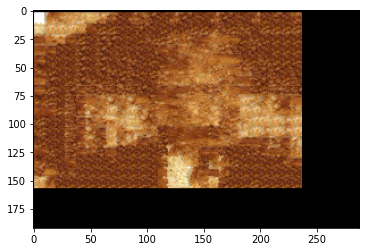

In [368]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/toast.jpg' # feel free to change
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)

guidance_img_fn = 'samples/trump_small.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

patch_size = 11
overlap = 2
tol = 1
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

#plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [ ]:
#Make cut on minimum path
def customCut(patch, block_size, overlap, newarray, start_y, start_x, start_y1,start_x1):
    #Make copy of patch
    patch = patch.copy()
    #Get patch shape
    dy, dx, _ = patch.shape
    #Zero Matrix
    minCut = np.zeros_like(patch, dtype=bool)
    #Conditions for cutting vertically and horizontally
    if start_x > start_x1:
        error_left = patch[:, :overlap] - newarray[start_y:start_y+dy, start_x:start_x+overlap]
        leftL2 = np.sum(error_left**2, axis=2)
        for i, j in enumerate(cuttingPath(leftL2)):
            minCut[i, :j] = True

    if start_y > start_y1:
        error_up = patch[:overlap, :] - newarray[start_y:start_y+overlap, start_x:start_x+dx]
        upL2 = np.sum(error_up**2, axis=2)
        for j, i in enumerate(cuttingPath(upL2.T)):
            minCut[:i, j] = True

    np.copyto(patch, newarray[start_y:start_y+dy, start_x:start_x+dx], where=minCut)
    return patch

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [ ]:
#Not claiming

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [ ]:
#See report for face in toast image